# ランキング学習（LGBMRanker）による勝率分析

## 本題
true skillsを用いて各馬の強さを数値化したい
## 方法
前走までのレーティングを計算し、それを特徴量に含める
## 結果
弱い馬が上位に入ってしまうこともあったが、おおよそ強い馬が上位に来るようになった
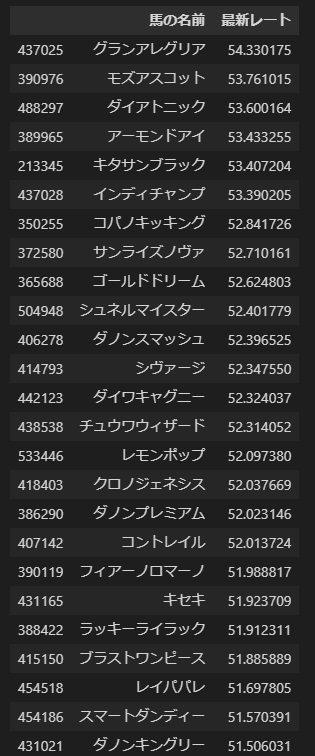

- 参考：https://qiita.com/kazuktym/items/3aa1f9e10d9231cf5cab#%E3%83%AC%E3%83%BC%E3%82%B9%E3%81%AF%E7%9B%B8%E5%AF%BE%E8%A9%95%E4%BE%A1%E3%81%A7%E4%BA%88%E6%83%B3%E3%81%97%E3%81%9F%E3%81%84

In [155]:
import pandas as pd
import tqdm

import os
import sys
sys.path.append('../../')
import common.com as common
from common import const,utils
import copy
from datetime import datetime
import scraping.scraping as scraping


In [2]:
# # DBにある全てのレースデータを重複を排除して取得（2024/06/01実行時点では2013-01_2023-12のデータ）
_data = common.get_race_data_distinct()
data=pd.DataFrame(_data,columns=const.ORIGIN_RACE_DATA_HEADERS)

In [21]:
# data=pd.read_csv('D://work//Programming//data//race_datas//2013-01_2023-12.csv',header=0)

In [3]:
# ラベルエンコーディング(LabelEncoder)
from sklearn.preprocessing import LabelEncoder

encode_tar_cols = [
'性',
'斤量',
'芝かダートか',
'回り',
'馬場状態',
'天気',]

encoded = copy.deepcopy(data)

le = LabelEncoder()
for col in encode_tar_cols:
    encoded[col] = le.fit_transform(encoded[col].values)

In [4]:
# 着順関連度で重み付け
ORDER_RELATED = {1:30,2:28,3:26,4:24,5:22}
def get_order_related(order):
    try:
        return ORDER_RELATED[order]
    except KeyError:
        return 0
    
encoded['着順関連度'] = encoded['着順'].map(get_order_related)

In [5]:
encoded['オッズ'] = encoded['オッズ'].replace('---',0).astype(float)

In [6]:

# objectになってしまうので、floatに変換
for col in const.VARIABLE[:-1]:
    if encoded[col].dtype == 'object':
        if col in ['レースID','馬番','枠番','齢','馬のID','騎手のID','距離','競馬場ID']:
            encoded[col] = encoded[col].astype('int64')
        else:
            encoded[col] = encoded[col].astype(float)

In [9]:
# レースIDでグループ化
grouped_data = encoded.groupby('レースID')

In [40]:
import trueskill
mu = 25.
sigma = mu / 3.
beta = sigma / 2.
tau = sigma / 100.
draw_probability = 0.001
backend = None
env = trueskill.TrueSkill(
    mu=mu, sigma=sigma, beta=beta, tau=tau,
    draw_probability=draw_probability, backend=backend)


In [132]:
# レースごとにレーティング

uma_list = list(encoded.loc[:,'馬のID'].unique())
# 全馬のレートを初期化
all_horse_rate_dict = {k:env.create_rating() for k in uma_list}
rate_before_ = []
race_rate_ = []
race_after_ = []
result = pd.DataFrame(columns=encoded.columns.to_list().append(['直前レート','最新レート']))
i =0
for race_id,df_race in tqdm.tqdm(grouped_data):    
    rate_before = [env.expose(all_horse_rate_dict[el[8]]) for el in list(df_race.values)]
    # rate_mean = sum(rate_before)/len(rate_before)
    # チームを作成（1頭チーム x レースに出場する馬数）
    teams = [(all_horse_rate_dict[el[8]],) for el in list(df_race.values)]
    # レーティング
    teams = env.rate(teams, ranks=list(df_race['着順'].map(lambda x:x-1)))
    rate_after = [env.expose(t[0]) for t in teams]
    # race_rate = [(x-rate_mean)/(rate_mean + 0.001)*100 for x in rate_after]
    for i, el in enumerate(list(df_race.values)):
        # レートが高い方で更新
        all_horse_rate_dict[el[8]] = max(all_horse_rate_dict[el[8]], teams[i][0])

    df_race['直前レート']=rate_before
    df_race['最新レート']=rate_after
    result=pd.concat([result,df_race])

100%|██████████| 37986/37986 [37:25<00:00, 16.92it/s]


In [137]:
result.to_csv(const.BASE_DIR+'predict//LGBMRanker02//ranked_race_data.csv')

In [160]:
# 8:2の割合で、学習用と評価用に分割
grouped_data_list = list(result.groupby('レースID'))
learn_count = round(len(grouped_data_list) * 0.8)

learn_grouped_data = grouped_data_list[:learn_count]
test_grouped_data = grouped_data_list[learn_count:]

# 8:2の割合で、訓練用と検証用に分割
train_count = round(len(learn_grouped_data) * 0.8)
train_grouped_data = learn_grouped_data[:train_count]
valid_grouped_data = learn_grouped_data[train_count:]

In [168]:
# 直前のレースまでのレートを特徴量に含めたうえで学習
target_variables=copy.deepcopy(const.VARIABLE)
target_variables.append('直前レート')
X_train = pd.concat([item[1].loc[:,target_variables] for item in train_grouped_data])
X_valid = pd.concat([item[1].loc[:,target_variables] for item in valid_grouped_data])
X_test = pd.concat([item[1].loc[:,target_variables] for item in test_grouped_data])
y_train = pd.concat([item[1].loc[:,'着順関連度'] for item in train_grouped_data])
y_valid = pd.concat([item[1].loc[:,'着順関連度'] for item in valid_grouped_data])
y_test = pd.concat([item[1].loc[:,'着順関連度'] for item in test_grouped_data])

In [169]:
# クエリーデータ(レース単位のデータ数のリスト)を作成
train_query = X_train.groupby('レースID').size().values.tolist()
valid_query = X_valid.groupby('レースID').size().values.tolist()

In [170]:
import lightgbm as lgb

model = lgb.LGBMRanker(
  random_state=100,              # 乱数シード
  n_estimators=500,              # 決定木の個数(default:100)
  learning_rate=0.01,            # 学習率(default:0.1)
  num_leaves=100,                 # 決定木にある分岐の個数(default:31)
  max_depth=-1,                  # 決定木の深さの最大値(default:-1)
  min_child_samples=150,         # 一つの葉に含まれる最小データ数(default:20) 
)

model.fit(X_train, y_train,
  group=train_query,             # 訓練用クエリーデータ
  eval_set=[(X_valid, y_valid)], # 学習時に用いる検証用データ
  eval_group=[valid_query],      # 検証用クエリーデータ
  eval_metric='ndcg',            # 学習時の評価手法
  eval_at=[1, 2, 3,4,5]              # 学習時の評価対象順位
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 347498, number of used features: 19


LGBMRanker(learning_rate=0.01, min_child_samples=150, n_estimators=500,
           num_leaves=100, random_state=100)

In [171]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

# 予測結果や関連度をDataFrameに連結
df_pred = pd.DataFrame({
    'レースID': X_test['レースID'],
    '馬番号': X_test['馬のID'],
    '予想スコア':  y_pred,
    '着順関連度': y_test,
})

In [186]:
df_pred.to_csv(const.BASE_DIR+'predict//LGBMRanker02//predict.csv')

In [172]:
# 特徴量重要度の抽出
df_importances = pd.DataFrame({'columns':X_train.columns, 'importances':model.feature_importances_})
df_importances.sort_values('importances', ascending=False, inplace=True)
print(df_importances)

   columns  importances
8      オッズ         7198
18   直前レート         6916
7    騎手のID         4935
10      体重         4783
6     馬のID         4592
0    レースID         3937
2       馬番         2524
11    体重変化         2491
17   競馬場ID         2185
13      距離         1910
9       人気         1492
4        齢         1425
5       斤量         1396
1       枠番         1280
16      天気          573
12  芝かダートか          530
15    馬場状態          495
14      回り          449
3        性          389


In [173]:
from sklearn.metrics import ndcg_score
# クエリーごとにNDCGを計算し、その平均値を算出
ndcg_score = df_pred.groupby('レースID').apply(lambda d: ndcg_score([d['着順関連度']], [d['予想スコア']], k=5)).mean()
print(ndcg_score)

0.6758820613875128


C:\Users\ionde\AppData\Local\Temp\ipykernel_21416\245059073.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg_score = df_pred.groupby('レースID').apply(lambda d: ndcg_score([d['着順関連度']], [d['予想スコア']], k=5)).mean()


In [174]:
import pickle
# モデルの保存
file_dir = const.BASE_DIR+'predict//LGBMRanker02//LGBMRanker02.pickle'
pickle.dump(model, open(file_dir, 'wb'))

In [189]:
check=result.groupby('馬のID')
sorted_by_rate = copy.deepcopy(result.loc[check['日付'].idxmax(),:])
sorted_by_rate[['馬の名前','最新レート']].sort_values(by='最新レート',ascending=False).head(50)

,馬の名前,最新レート
437025,グランアレグリア,54.330175
390976,モズアスコット,53.761015
488297,ダイアトニック,53.600164
389965,アーモンドアイ,53.433255
437028,インディチャンプ,53.390205
350255,コパノキッキング,52.841726
390973,ゴールドドリーム,52.597418
438538,チュウワウィザード,52.314052
249155,キタサンブラック,52.228444
531917,シュネルマイスター,52.142561
